# Understanding PolSpice

## Goal
The goal of this notebook is to understand the Polspice method as described in Camphius et al. (2204.13721) and Chon et al. (0303414). In order to do so we will assume that we have observed a spin-2 complex field covering about 10% of the sky and measured its partial sky angular power spectra for the different fields ($\tilde{C}_\ell^{TT}$, $\tilde{C}_\ell^{EE}$ and $\tilde{C}_\ell;^{BB}$). Then, we aim to recover the full sky angular power spectra ($C_\ell^{TT}$, $C_\ell^{EE}$ and $C_\ell^{BB}$) using the Polspice method and match it with a theory prediction.




## Dependencies

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
import camb
import heracles

from camb.sources import SplinedSourceWindow

## Make data

We will use a Gaussian simulation to generate the map and then apply a square mask to it. The final masked map covers ~10% of the sky.

In [2]:
nside = 2048
lmax = 2500
nlbins = 20

In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67., omch2=0.270*0.67**2, ombh2=0.049*0.67**2)
pars.InitPower.set_params(As=2.1e-9, ns=0.96)
pars.Want_CMB = False
pars.NonLinear = camb.model.NonLinear_both
pars.set_for_lmax(lmax+100, lens_potential_accuracy=1);

In [4]:
z = np.linspace(0, 3, 300)
nz = np.exp(-((0.3-z)/0.1)**2)
bz = 0.83070341 + 1.19054721*z - 0.92835749*z**2 + 0.42329232*z**3
sources = []
sources += [
    SplinedSourceWindow(source_type='counts', z=z, W=nz, bias_z=bz),
    SplinedSourceWindow(source_type='lensing', z=z, W=nz)]
pars.SourceWindows = sources

In [5]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=lmax, raw_cl=True)

l = np.arange(lmax+1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

fl = -np.sqrt((l+2)*(l+1)*l*(l-1))
fl /= np.clip(l*(l+1), 1, None)

theory_cls = {}
# all mixing matrix combinations
key = ("POS", "POS", 1, 1)
cl = np.array(camb_cls['W1xW1'])
theory_cls[key] = heracles.Result(cl, axis=(0,), ell=l)

key = ("POS", "SHE", 1, 1)
cl = np.array([camb_cls['W2xW1'] * fl,
               np.zeros(lmax+1)])
theory_cls[key] = heracles.Result(cl, axis=(1,), ell=l)

key = ("SHE", "SHE", 1, 1)
cl = np.array(
    [
        [camb_cls['W2xW2'] * fl**2, np.zeros(lmax+1)],
        [np.zeros(lmax+1), np.zeros(lmax+1)],
    ]
)
theory_cls[key] = heracles.Result(cl, axis=(2,), ell=l)

In [6]:
theory_map = hp.sphtfunc.synfast([
        camb_cls['W1xW1'],
        camb_cls['W2xW2'] * fl**2,
        np.zeros(lmax+1),
        camb_cls['W2xW1'] * fl],
        nside, new=True)

### Make Mask

In [7]:
mask = np.ones_like(theory_map[1])
pixel_theta, pixel_phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
mask_type = 'Patch'

if mask_type == 'Patch':
    mask[np.pi/3 > pixel_theta] = 0.0
    mask[pixel_theta > 2*np.pi/3] = 0.0
    mask[pixel_phi > np.pi/2] = 0.0
    mask[np.pi/8> pixel_phi] = 0.0

if mask_type == 'One third cover':
    mask[np.pi/3 > pixel_theta] = 0.0

if mask_type == 'Half cover':
        mask[np.pi/2 > pixel_theta] = 0.0

if mask_type == 'Two thirds cover':
        mask[2*np.pi/3 > pixel_theta] = 0.0

map_t = theory_map[0]*mask
map_q = theory_map[1]*mask
map_u = theory_map[2]*mask

In [8]:
npix = hp.nside2npix(nside)
fsky = 1
ngal = 1.0
wmean = 1.0
var = 1.0
bias = 0.0 #4 * np.pi * fsky**2 * (var / wmean**2) / ngal
nbar = (ngal * wmean) / (fsky * npix)

map_she = np.array([map_q, map_u])
heracles.update_metadata(
    map_t,
    geometry='healpix',
    kernel='healpix',
    deconv=True,
    catalog=None,
    nside=nside,
    lmax=lmax,
    ngal=ngal,
    nbar=nbar,
    wmean=wmean,
    bias=bias,
    var=var,
    variance=var / wmean**2,
    neff=ngal / (4 * np.pi * fsky),
    fsky=fsky,
    spin=0,
)
heracles.update_metadata(
    map_she,
    geometry='healpix',
    kernel='healpix',
    deconv=True,
    catalog=None,
    nside=nside,
    lmax=lmax,
    ngal=ngal,
    nbar=nbar,
    wmean=wmean,
    bias=bias,
    var=var,
    variance=var / wmean**2,
    neff=ngal / (2 * np.pi * fsky),
    fsky=fsky,
    spin=2,
)
data_maps = {}
data_maps[("POS", 1)] = map_t
data_maps[("SHE", 1)] = map_she

vis_maps = {}
vis_maps[("VIS", 1)] =  np.ones_like(map_t)*mask
vis_maps[("WHT", 1)] = np.ones_like(map_t)*mask

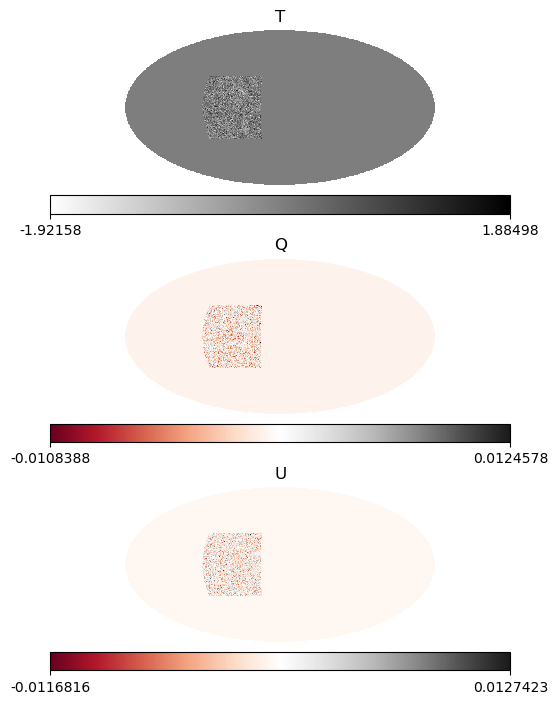

In [9]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(data_maps['POS', 1], cmap='binary', title='T', hold=True)
plt.sca(ax[1])
hp.mollview(data_maps['SHE', 1][0], cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(data_maps['SHE', 1][1], cmap='RdGy', title='U', hold=True)
plt.show()

In [10]:
print("fsky: ", np.mean(mask))

fsky:  0.093780517578125


### Make Cls

In [11]:
import heracles.healpy
mapper = heracles.healpy.HealpixMapper(nside, lmax)
fields = {
    "POS": heracles.Positions(mapper, mask="VIS"),
    "SHE": heracles.Shears(mapper, mask="WHT"),
    "VIS": heracles.Visibility(mapper),
    "WHT": heracles.Weights(mapper),
}

In [12]:
alms = heracles.transform(fields, data_maps)
cls0 = heracles.angular_power_spectra(alms)

In [13]:
alms = heracles.transform(fields, vis_maps)
mls0 = heracles.angular_power_spectra(alms)

[]

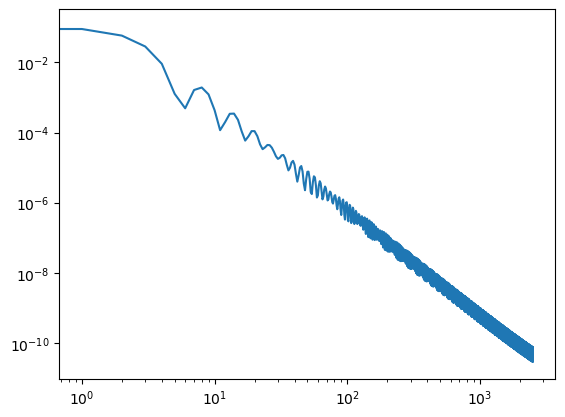

In [14]:
plt.plot(mls0["VIS", "VIS", 1, 1].array, label='PP')
plt.loglog()

In [15]:
cqs0 = heracles.binned(cls0, ledges)

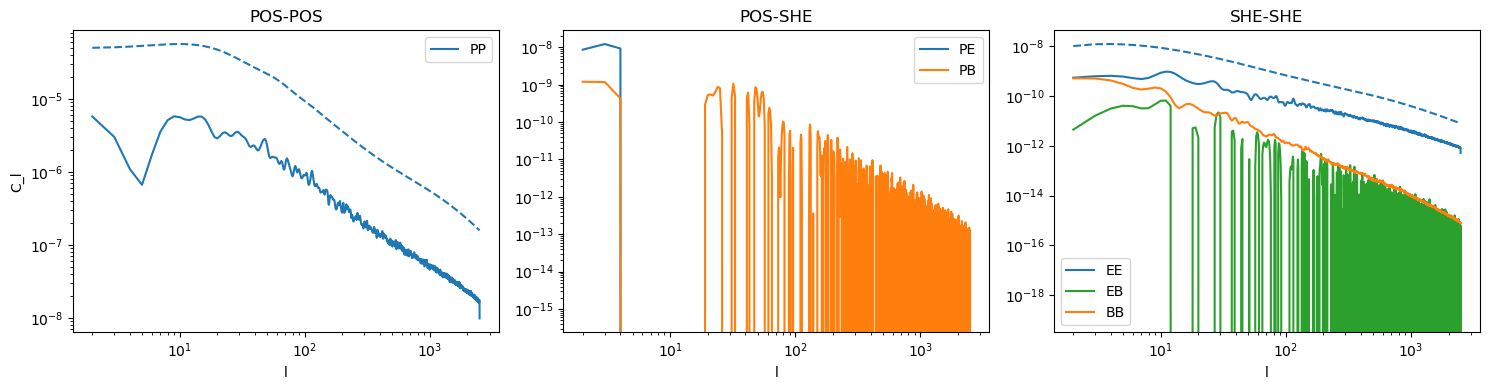

In [16]:
# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
axs[0].plot(l[2:], cls0[("POS", "POS", 1, 1)].array[2:], color='C0', label='PP')
axs[0].plot(l[2:], theory_cls[("POS", "POS", 1, 1)].array[2:], color='C0', linestyle='--')
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("l")
axs[0].set_ylabel("C_l")

# POS SHE
axs[1].plot(l[2:], cls0[("POS", "SHE", 1, 1)].array[0][2:], color='C0', label='PE')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[0][2:], color='C0', linestyle='--')
axs[1].plot(l[2:], cls0[("POS", "SHE", 1, 1)].array[1][2:], color='C1', label='PB')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[1][2:], color='C1', linestyle='--')
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("l")

# SHE SHE
axs[2].plot(l[2:], cls0[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', label='EE')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', linestyle='--')
axs[2].plot(l[2:], cls0[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', label='EB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', linestyle='--')
axs[2].plot(l[2:], cls0[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', label='BB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', linestyle='--')
axs[2].legend()
axs[2].set_title("SHE-SHE")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()

## Polspice

In [17]:
mask_cls = mls0['VIS', 'VIS', 1, 1].array
data_cls = {}
data_cls['TT'] = cls0['POS', 'POS', 1, 1].array
data_cls['EE'] = cls0['SHE', 'SHE', 1, 1][0, 0]
data_cls['BB'] = cls0['SHE', 'SHE', 1, 1][1, 1]

In [18]:
from heracles.transforms import cl2corr, corr2cl, _cached_gauss_legendre
from heracles.unmixing import Eq90_plus, Eq90_minus, logistic

#Polspice
# Compute the correlation function of the data
corr_x, corr_w = _cached_gauss_legendre(l[-1]+1)

prefac = l * (l + 1) / (2 * np.pi)
cls_for_corr = np.array([
    data_cls['TT'],
    data_cls['EE'],
    data_cls['BB'],
    np.zeros(lmax+1)])
data_corr = cl2corr(cls_for_corr.T).T
xi_TT = data_corr[0]
xi_p  = data_corr[1]
xi_m  = data_corr[2]

# Compute the correlation function of the mask
mask_for_corr = np.transpose([
  mask_cls,
  np.zeros(lmax+1),
  np.zeros(lmax+1),
  np.zeros(lmax+1)])
mask_corr = cl2corr(mask_cls).T

xi_mask = mask_corr[0]
xi_mask *= logistic(np.log10(abs(xi_mask)))

In [19]:
### With Integrals
# Plus
xi_eq90_plus = Eq90_plus(corr_x, xi_p)/xi_mask
pols_plus_corrs_1 = np.array([
    np.zeros(lmax+1),
    np.zeros(lmax+1),
    xi_eq90_plus,
    np.zeros(lmax+1)])
pols_plus_1_cls_list = corr2cl(pols_plus_corrs_1.T).T

pols_plus_corrs_2 = np.array([
    np.zeros(lmax+1),
    np.zeros(lmax+1),
    xi_m/xi_mask,
    np.zeros(lmax+1)])
pols_plus_2_cls_list = corr2cl(pols_plus_corrs_2.T).T

eq90_plus_pols_cls = {}
eq90_plus_pols_cls['TT'] = np.zeros(lmax+1)
eq90_plus_pols_cls['EE'] = -(pols_plus_1_cls_list[2]+pols_plus_2_cls_list[2])
eq90_plus_pols_cls['BB'] = (pols_plus_1_cls_list[2]-pols_plus_2_cls_list[2])

# Minus
xi_eq90_minus = Eq90_minus(corr_x, xi_m)/xi_mask
pols_minus_corrs_1 = np.array([
    np.zeros(lmax+1),
    xi_p/xi_mask, 
    np.zeros(lmax+1),
    np.zeros(lmax+1)])
pols_minus_1_cls_list = corr2cl(pols_minus_corrs_1.T).T

pols_minus_corrs_2 = np.array([
    np.zeros(lmax+1),
    xi_eq90_minus,
    np.zeros(lmax+1),
    np.zeros(lmax+1)])
pols_minus_2_cls_list = corr2cl(pols_minus_corrs_2.T).T

eq90_minus_pols_cls = {}
eq90_minus_pols_cls['TT'] = np.zeros(lmax+1)
eq90_minus_pols_cls['EE'] = (pols_minus_1_cls_list[1]+pols_minus_2_cls_list[1])
eq90_minus_pols_cls['BB'] = (pols_minus_1_cls_list[1]-pols_minus_2_cls_list[1])

pp_cls = {}
pp_cls[('POS', 'POS', 1, 1)] = heracles.Result(
    eq90_plus_pols_cls['TT'], axis=(0,), ell=l)
pp_cls[('SHE', 'SHE', 1, 1)] = heracles.Result(
    np.array([[eq90_plus_pols_cls['EE'], np.zeros(lmax+1)],
              [np.zeros(lmax+1), eq90_plus_pols_cls['BB']]]),
    axis=(2,), ell=l)
pp_cls[('POS', 'SHE', 1, 1)] = heracles.Result(
    np.array([np.zeros(lmax+1), np.zeros(lmax+1)]),
    axis=(1,), ell=l)

pm_cls = {}
pm_cls[('POS', 'POS', 1, 1)] = heracles.Result(
    eq90_minus_pols_cls['TT'], axis=(0,), ell=l)
pm_cls[('SHE', 'SHE', 1, 1)] = heracles.Result(
    np.array([[eq90_minus_pols_cls['EE'], np.zeros(lmax+1)],
              [np.zeros(lmax+1), eq90_minus_pols_cls['BB']]]),
    axis=(2,), ell=l)
pm_cls[('POS', 'SHE', 1, 1)] = heracles.Result(
    np.array([np.zeros(lmax+1), np.zeros(lmax+1)]),
    axis=(1,), ell=l)

In [20]:
nu_cls = heracles.unmixing.natural_unmixing(cls0, mls0, patch_hole=True)
pp_cls = heracles.unmixing.PolSpice(cls0, mls0, mode='plus', patch_hole=True)
pm_cls = heracles.unmixing.PolSpice(cls0, mls0, mode='minus', patch_hole=True)

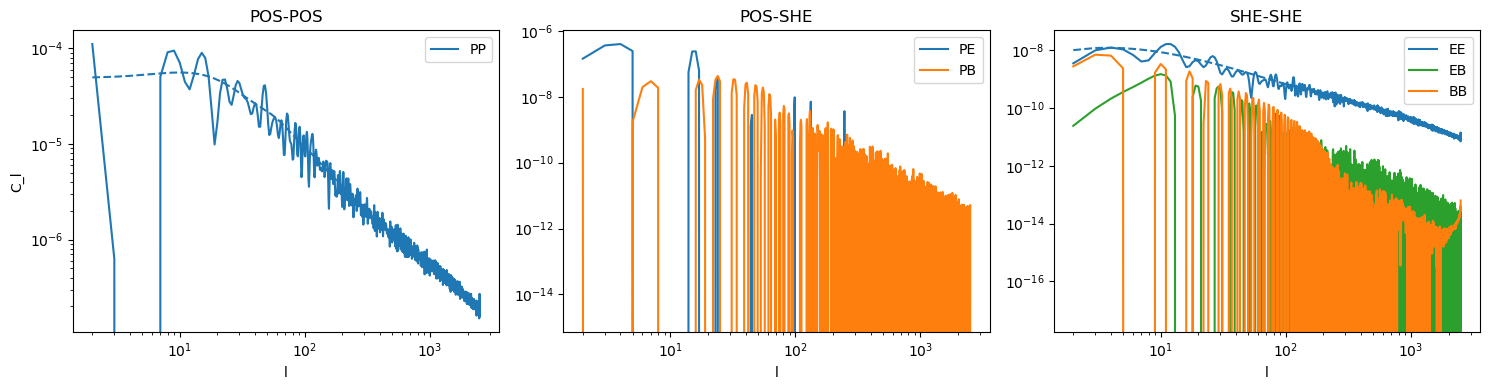

In [21]:
# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
axs[0].plot(l[2:], nu_cls[("POS", "POS", 1, 1)].array[2:], color='C0', label='PP')
axs[0].plot(l[2:], theory_cls[("POS", "POS", 1, 1)].array[2:], color='C0', linestyle='--')
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("l")
axs[0].set_ylabel("C_l")

# POS SHE
axs[1].plot(l[2:], nu_cls[("POS", "SHE", 1, 1)].array[0][2:], color='C0', label='PE')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[0][2:], color='C0', linestyle='--')
axs[1].plot(l[2:], nu_cls[("POS", "SHE", 1, 1)].array[1][2:], color='C1', label='PB')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[1][2:], color='C1', linestyle='--')
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("l")

# SHE SHE
axs[2].plot(l[2:], nu_cls[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', label='EE')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', linestyle='--')
axs[2].plot(l[2:], nu_cls[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', label='EB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', linestyle='--')
axs[2].plot(l[2:], nu_cls[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', label='BB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', linestyle='--')
axs[2].legend()
axs[2].set_title("SHE-SHE")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()

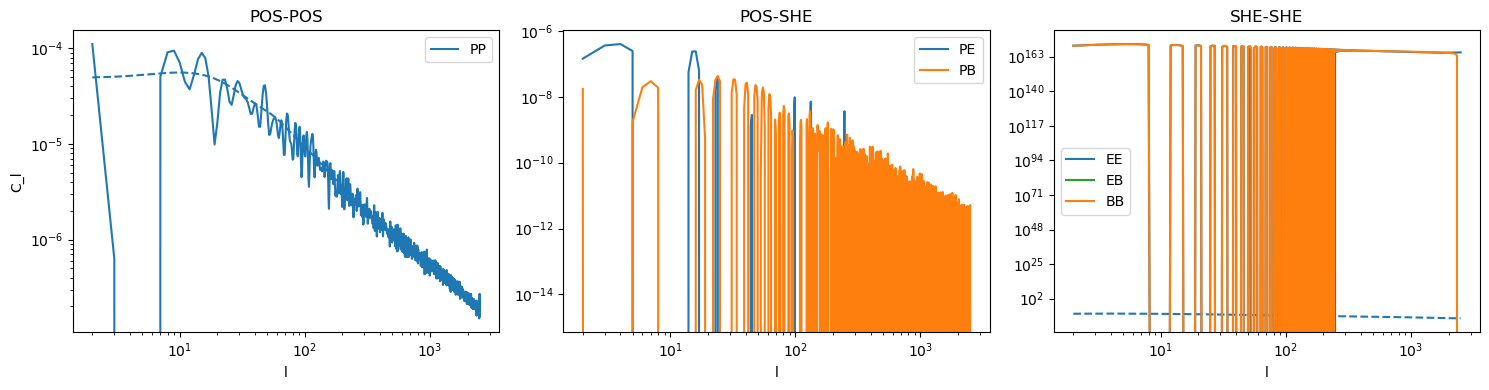

In [22]:
# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
axs[0].plot(l[2:], pp_cls[("POS", "POS", 1, 1)].array[2:], color='C0', label='PP')
axs[0].plot(l[2:], theory_cls[("POS", "POS", 1, 1)].array[2:], color='C0', linestyle='--')
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("l")
axs[0].set_ylabel("C_l")

# POS SHE
axs[1].plot(l[2:], pp_cls[("POS", "SHE", 1, 1)].array[0][2:], color='C0', label='PE')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[0][2:], color='C0', linestyle='--')
axs[1].plot(l[2:], pp_cls[("POS", "SHE", 1, 1)].array[1][2:], color='C1', label='PB')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[1][2:], color='C1', linestyle='--')
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("l")

# SHE SHE
axs[2].plot(l[2:], pp_cls[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', label='EE')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', linestyle='--')
axs[2].plot(l[2:], pp_cls[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', label='EB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', linestyle='--')
axs[2].plot(l[2:], pp_cls[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', label='BB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', linestyle='--')
axs[2].legend()
axs[2].set_title("SHE-SHE")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()

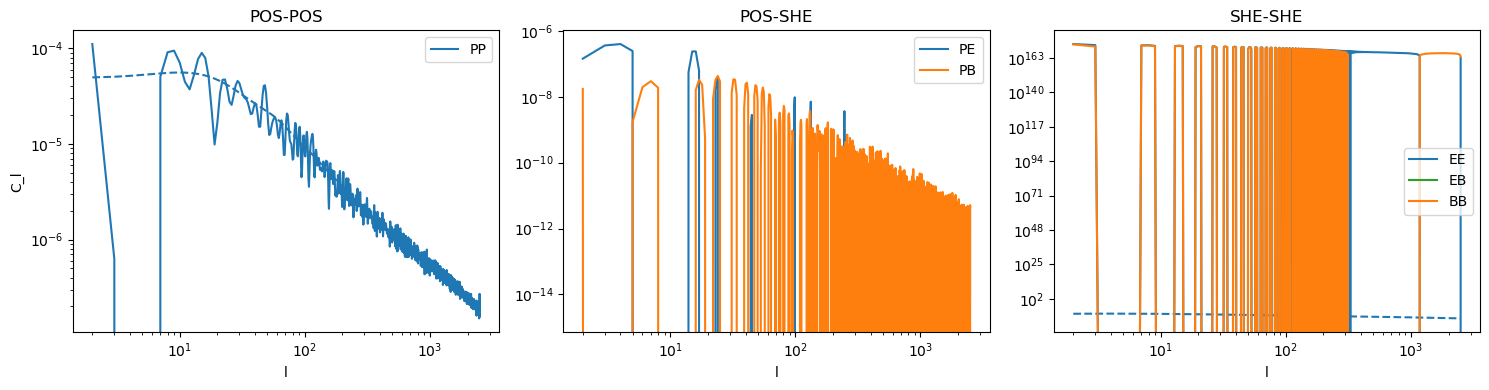

In [23]:
# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# POS POS
axs[0].plot(l[2:], pm_cls[("POS", "POS", 1, 1)].array[2:], color='C0', label='PP')
axs[0].plot(l[2:], theory_cls[("POS", "POS", 1, 1)].array[2:], color='C0', linestyle='--')
axs[0].legend()
axs[0].set_title("POS-POS")
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel("l")
axs[0].set_ylabel("C_l")

# POS SHE
axs[1].plot(l[2:], pm_cls[("POS", "SHE", 1, 1)].array[0][2:], color='C0', label='PE')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[0][2:], color='C0', linestyle='--')
axs[1].plot(l[2:], pm_cls[("POS", "SHE", 1, 1)].array[1][2:], color='C1', label='PB')
axs[1].plot(l[2:], theory_cls[("POS", "SHE", 1, 1)].array[1][2:], color='C1', linestyle='--')
axs[1].legend()
axs[1].set_title("POS-SHE")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel("l")

# SHE SHE
axs[2].plot(l[2:], pm_cls[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', label='EE')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 0][2:], color='C0', linestyle='--')
axs[2].plot(l[2:], pm_cls[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', label='EB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[0, 1][2:], color='C2', linestyle='--')
axs[2].plot(l[2:], pm_cls[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', label='BB')
axs[2].plot(l[2:], theory_cls[("SHE", "SHE", 1, 1)].array[1, 1][2:], color='C1', linestyle='--')
axs[2].legend()
axs[2].set_title("SHE-SHE")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel("l")

# Adjust layout
plt.tight_layout()
plt.show()